# **ALEXNet CNN for Smoking Images Classification**

## **Data Loading**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import torch
import torchvision
import tarfile
from zipfile import ZipFile
from torchvision.datasets.utils import download_url
from torch.utils.data import random_split

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
with ZipFile('/content/drive/MyDrive/custom_dataset.zip', 'r') as zip:
    zip.extractall(path='./data')

In [ ]:
dir_path='./data/dataset/'
folders= os.listdir(dir_path)
print(folders)
for i in folders:
  print(os.listdir(dir_path+'/'+i))

['test', 'train']
['notsmoking', 'smoking']
['notsmoking', 'smoking']


In [ ]:
import cv2
from PIL import Image
import numpy as np

cates = ['smoking', 'notsmoking']
def load_images_and_labels(data_path, cates): 
  X = []
  y = []
  i = 0
  for index, cate in enumerate(cates): 
    for img_name in os.listdir(data_path + cate + '/'):
      i = i +1
      print(i)
      img = cv2.imread(data_path + cate + '/' + img_name)
      if img is not None: 
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img_array = Image.fromarray(img, 'RGB')
        # resize image to 227x227 which is the required input size of the Alexnet model
        img_rs = img_array.resize((227,227))
        # convert the image to array
        img_rs = np.array(img_rs)
      
        X.append(img_rs)
        y.append(index)
  return X, y

In [ ]:
X_train, y_train = load_images_and_labels('/content/data/dataset/train/', cates)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160


In [ ]:
X_test, y_test = load_images_and_labels("/content/data/dataset/test/", cates)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40


In [ ]:
data_dict = {'X_train' : X_train, 
             'y_train': y_train,
             'X_test': X_test, 
             'y_test': y_test}
np.save('data_dict.npy', data_dict)

In [ ]:
data_dict_ = np.load('data_dict.npy', allow_pickle = True).item()
X_train = data_dict_['X_train']
y_train = data_dict_['y_train']
X_test = data_dict_['X_test']
y_test = data_dict_['y_test']

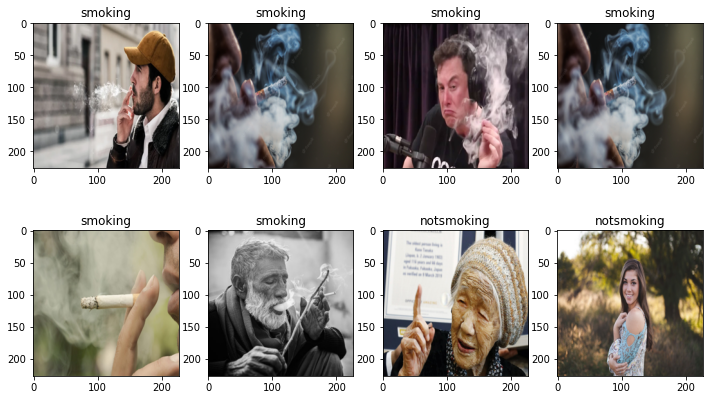

In [ ]:
import matplotlib.pyplot as plt
import random

plt.figure(figsize = (12,7))
cate = ['smoking', 'notsmoking']
for i in range(8):
  ind = random.randint(0, len(X_train))
  plt.subplot(240 + 1 + i)
  plt.imshow(X_train[ind])
  plt.title(cate[y_train[ind]])

## **Data Preprocessing**

In [ ]:
from tensorflow.keras.utils import to_categorical

def preprocess_data(X, y):
  # convert X from list to array
  X = np.array(X)
  
  # convert integer values of X into floats
  X = X.astype(np.float32)

  # normalization 
  X = X/255.0
  
  # one-hot encoding the labels 
  y = to_categorical(np.array(y))
    
  return X, y
  
(X_train, y_train) = preprocess_data(X_train, y_train)
(X_test, y_test) = preprocess_data(X_test, y_test)

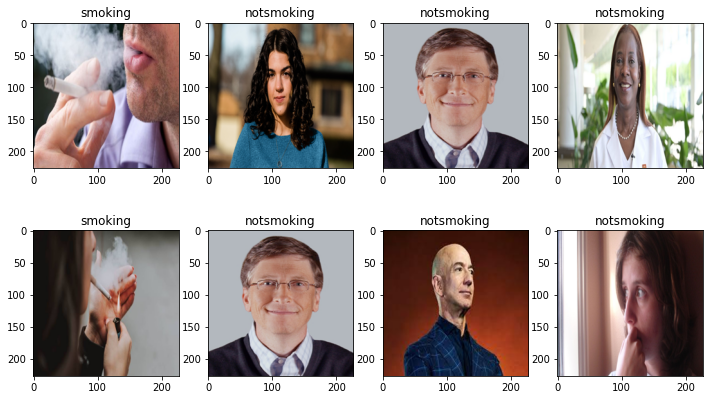

In [ ]:
plt.figure(figsize = (12,7))
for i in range(8):
  ind = random.randint(0, len(X_train))
  plt.subplot(240 + 1 + i)
  plt.imshow(X_train[ind])
  plt.title(cate[np.argmax(y_train[ind])])

## **ALEXNet Model**

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
# metric
from tensorflow.keras.metrics import binary_crossentropy
# optimization method (Stochastic Gradient Descent (SGD))
from tensorflow.keras.optimizers import SGD

In [ ]:
def Alexnet():
  # Initialize the model
  model = Sequential()

  # layer 1: convolutional layer + max-pooling layer
  model.add(Conv2D(filters = 96, kernel_size = (11,11), strides= 4, padding = 'valid', 
                   activation='relu', input_shape = (227,227,3)))
  model.add(MaxPooling2D(pool_size = (3,3), strides = 2))

  # layer 2: convolutional layer + max-pooling layer 
  model.add(Conv2D(filters = 256, kernel_size = (5,5), padding = 'same', 
                   activation = 'relu'))
  model.add(MaxPooling2D(pool_size = (3,3), strides = 2))

  # layers 3-5: three convolutional layers + 1 max-pooling layer
  model.add(Conv2D(filters = 384, kernel_size = (3,3), padding = 'same', 
                   activation = 'relu'))
  model.add(Conv2D(filters = 384, kernel_size = (3,3), padding = 'same', 
                   activation = 'relu'))
  model.add(Conv2D(filters = 256, kernel_size = (3,3), padding = 'same', 
                   activation = 'relu'))
  model.add(MaxPooling2D(pool_size = (3,3), strides = 2))

  # layers 6 - 8: two fully connected hidden layers and one fully connected output layer
  model.add(Flatten())
  model.add(Dense(4096, activation = 'relu'))
  model.add(Dropout(0.5))
  model.add(Dense(4096, activation = 'relu'))
  model.add(Dropout(0.5))
  model.add(Dense(2, activation = 'softmax'))

  # compile the model with a loss funciton, a metric and and optimizqation method
  opt = SGD(lr = 0.1)
  model.compile(loss = binary_crossentropy,
                optimizer = opt,
                metrics = ['accuracy'])

  return model

In [ ]:
Alexnet_model = Alexnet()
Alexnet_model.summary()
#Alexnet.to(device)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 55, 55, 96)        34944     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 27, 27, 96)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 27, 27, 256)       614656    
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 13, 13, 256)      0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 13, 13, 384)       885120    
                                                                 
 conv2d_8 (Conv2D)           (None, 13, 13, 384)      

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


## **Training the model**

In [ ]:

from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint

def train_model(model, X_train, y_train, X_test, y_test, epochs, batch_size):
  # Data generator
  datagen = ImageDataGenerator(rotation_range = 5, width_shift_range = 0.1, 
                               height_shift_range = 0.1, horizontal_flip = True)
  # iteration on the training set
  it_train = datagen.flow(X_train, y_train, batch_size = batch_size)
  # path to save the checkpoint 
  path_cp = os.getcwd() + '/' + 'weights_.hdf5'
  checkpoint_ = ModelCheckpoint(path_cp, monitor = 'loss', save_best_only = True, 
                                mode = 'auto')
  steps = X_train.shape[0]//batch_size
  # Fitting the model
  history = model.fit_generator(it_train, epochs = epochs, steps_per_epoch = steps, 
                                validation_data = (X_test, y_test), verbose = 1, 
                                callbacks = checkpoint_)
  # Evaluating the model
  _, acc = model.evaluate(X_test, y_test, verbose = 1)
  print('%.3f' % (acc * 100.0))
  
  return history, acc



In [ ]:
train_history, acc = train_model(Alexnet_model, X_train, y_train, X_test, y_test, 
                                 epochs = 100, batch_size = 10)

Epoch 1/100


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


16/16 [==============================] - 4s 249ms/step - loss: 0.7097 - accuracy: 0.5688 - val_loss: 0.6928 - val_accuracy: 0.5000
Epoch 2/100
16/16 [==============================] - 2s 144ms/step - loss: 0.6951 - accuracy: 0.4875 - val_loss: 0.6927 - val_accuracy: 0.5000
Epoch 3/100
16/16 [==============================] - 2s 148ms/step - loss: 0.6949 - accuracy: 0.5063 - val_loss: 0.6929 - val_accuracy: 0.5000
Epoch 4/100
16/16 [==============================] - 2s 149ms/step - loss: 0.6941 - accuracy: 0.4625 - val_loss: 0.6929 - val_accuracy: 0.5000
Epoch 5/100
16/16 [==============================] - 2s 115ms/step - loss: 0.6944 - accuracy: 0.4500 - val_loss: 0.6929 - val_accuracy: 0.5000
Epoch 6/100
16/16 [==============================] - 2s 115ms/step - loss: 0.6943 - accuracy: 0.4250 - val_loss: 0.6928 - val_accuracy: 0.5500
Epoch 7/100
16/16 [==============================] - 2s 149ms/step - loss: 0.6941 - accuracy: 0.4938 - val_loss: 0.6926 - val_accuracy: 0.5500
Epoch 8/100

## **Visualization**

In [ ]:
import pandas as pd

# convert the history.history to a pandas DataFrame:     
train_hist_df = pd.DataFrame(train_history.history) 

train_dict = {'train_hist': train_hist_df, 
              'acc': acc}
np.save('train_dict.npy', train_dict)

Alexnet_model.save('Alexnet_model.h5')

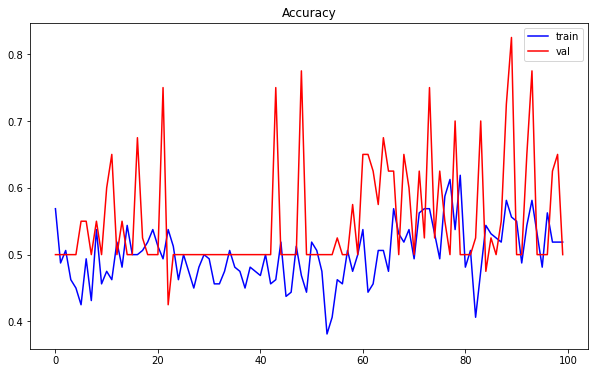

In [ ]:
def plot_accuracy(history):
  plt.figure(figsize = (10,6))
  plt.plot(history.history['accuracy'], color = 'blue', label = 'train')
  plt.plot(history.history['val_accuracy'], color = 'red', label = 'val')
  plt.legend()
  plt.title('Accuracy')
  plt.show()
  
plot_accuracy(train_history)

In [ ]:
y_test_pred = []
for i in np.arange(len(X_test)):
  img = X_test[i]
  img = img.reshape(1, 227, 227, 3)
  y_p = Alexnet_model.predict(img)
  y_test_pred.append(y_p)

y_test_pred = np.asarray(y_test_pred)

Text(69.0, 0.5, 'True classes')

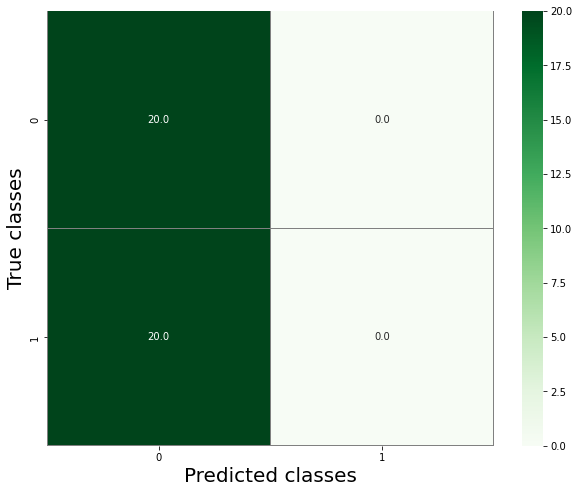

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns 

# Reverse the true and the predicted labels into the original binary 
# labels (0 and 1) to compute the confusion matrix
y_test_labels = [np.argmax(vect) for vect in y_test]
y_test_pred_labels = [np.argmax(vect) for vect in y_test_pred]

conf_mat = confusion_matrix(y_test_labels, y_test_pred_labels)

plt.figure(figsize = (10,8))
sns.heatmap(conf_mat, linewidths = 0.1, cmap = 'Greens', linecolor = 'gray', 
            fmt = '.1f', annot = True)
plt.xlabel('Predicted classes', fontsize = 20)
plt.ylabel('True classes', fontsize = 20)

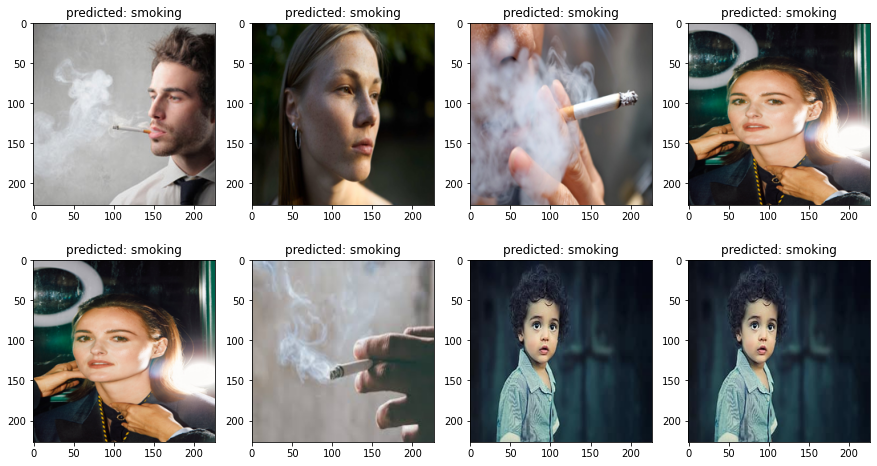

In [ ]:
plt.figure(figsize = (15,8))
for i in np.arange(8):
  # take randomly an indice
  ind = random.randint(0, len(X_test))
  img = X_test[ind]
  # reshape the image 
  img_rs = img.reshape(1,227,227,3)
  # predict the label of img
  y_pred = Alexnet_model.predict(img_rs)
  # determine the corresponding category
  predicted_cate = cate[np.argmax(y_pred)]
  plt.subplot(240+1+i)
  plt.imshow(img)
  plt.title('predicted: ' + str(predicted_cate))